In [240]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score
import json
import matplotlib.pyplot as plt
import numpy as np
import re

In [241]:
df = pd.read_csv('demographic.csv')
df = df.drop('index', axis=1)
df

/tmp/ipykernel_194483/466465776.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('demographic.csv')


,flag_bad,de_age,de_gender,de_date_joined,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_accomodation_type,de_education,...,de_children,ph_total_contacts,ph_other_device_info,ph_call_log_stats,ph_country_code,ph_app_list,fb_gender,fb_dob,fb_last_updated_date,fb_relation
0,0,26,1,08/04/2018 14:50,2535,3000000,1,51,4,2,...,0,66,"{""device_codename"": ""HM2014817"", ""brand"": ""Xia...","{""percent_incoming_nighttime"": 1.83, ""percent_...",id,"['com.google.android.music', 'com.facebook.orc...",male,11/23/1991,2017-12-21T04:38:00+0000,Married
1,0,22,1,02/01/2018 17:17,685,4000000,1,28,4,4,...,0,69,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.google.android.instantapps.supervisor', ...",male,01/20/1995,2017-11-25T17:23:09+0000,NaN
2,1,32,1,01/01/2018 16:39,1765,7000000,1,35,4,4,...,2,315,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 6.65, ""percent_...",id,"['com.tencent.ibg.joox', 'com.mrgames.larvaact...",male,10/13/1985,2017-12-23T18:05:57+0000,Married
3,0,31,2,04/01/2018 22:36,407,20000000,3,37,4,3,...,2,84,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.kfit.fave', 'app.bpjs.mobile', 'com.redd...",female,07/27/1986,2017-12-05T09:37:19+0000,Married
4,0,27,1,02/01/2018 18:12,3064,3000000,1,36,4,3,...,0,0,"{""device_codename"": ""1609"", ""brand"": ""vivo""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.lenovo.anyshare.gps', 'com.UCMobile.intl...",male,07/05/1990,2017-12-03T09:09:48+0000,In a relationship
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,11/07/2018 22:23,997,5000000,2,51,4,2,...,2,1026,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 5.66, ""percent_...",id,"['com.instagram.android', 'com.google.android....",NaN,NaN,NaN,NaN
41018,0,26,1,11/07/2018 20:28,955,3000000,2,24,4,2,...,0,0,"{""device_codename"": ""nikel"", ""brand"": ""Xiaomi""}","{""percent_incoming_nighttime"": 10.71, ""percent...",id,"['com.youmusic.magictiles', 'com.ayopop', 'com...",NaN,NaN,NaN,NaN
41019,0,22,2,11/07/2018 23:33,881,3000000,1,9,4,4,...,0,272,"{""device_codename"": ""a33g"", ""brand"": ""samsung""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.grabtaxi.passenger', 'jp.co.translimit.b...",female,10/02/1995,2017-10-25T08:05:13+0000,NaN
41020,0,29,2,11/07/2018 22:03,540,6000000,1,51,4,2,...,0,0,"{""device_codename"": ""santoni"", ""brand"": ""Xiaomi""}","{""percent_incoming_nighttime"": 1.27, ""percent_...",id,"['cn.wps.moffice_eng', 'com.vuclip.viu', 'com....",NaN,NaN,NaN,NaN


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  int64 
 3   de_date_joined          41022 non-null  object
 4   de_num_friends          41022 non-null  int64 
 5   de_monthly_salary       41022 non-null  int64 
 6   de_employment_type      41022 non-null  int64 
 7   de_employment_duration  41022 non-null  int64 
 8   de_accomodation_type    41022 non-null  int64 
 9   de_education            41022 non-null  int64 
 10  de_marital_status       41022 non-null  int64 
 11  de_children             41022 non-null  int64 
 12  ph_total_contacts       41022 non-null  int64 
 13  ph_other_device_info    41022 non-null  object
 14  ph_call_log_stats       38935 non-null  object
 15  ph

In [32]:
df.isna().sum()/len(df)

flag_bad                  0.000000
de_age                    0.000000
de_gender                 0.000000
de_date_joined            0.000000
de_num_friends            0.000000
de_monthly_salary         0.000000
de_employment_type        0.000000
de_employment_duration    0.000000
de_accomodation_type      0.000000
de_education              0.000000
de_marital_status         0.000000
de_children               0.000000
ph_total_contacts         0.000000
ph_other_device_info      0.000000
ph_call_log_stats         0.050875
ph_country_code           0.000609
ph_app_list               0.000000
fb_gender                 0.036883
fb_dob                    0.235313
fb_last_updated_date      0.035834
fb_relation               0.645044
dtype: float64

Check balanceness of data

In [5]:
df.flag_bad.value_counts()/len(df)

flag_bad
0    0.870313
1    0.129687
Name: count, dtype: float64

Not really unbalanced

In [6]:
df.de_accomodation_type.value_counts()

de_accomodation_type
4    41022
Name: count, dtype: int64

In [7]:
df.ph_country_code.value_counts()

ph_country_code
id    40984
us        3
sg        3
my        2
jp        2
tw        1
kh        1
th        1
Name: count, dtype: int64

Dont use these data, it is not varied enough

# Baseline Modelling

In [8]:
df.de_employment_type.value_counts()

de_employment_type
1    29566
2     6621
3     4833
4        2
Name: count, dtype: int64

In [9]:
df.de_education.value_counts()

de_education
2    24589
4     8258
3     5758
5     1561
1      856
Name: count, dtype: int64

In [10]:
df.de_children.value_counts()

de_children
0    23095
1     8921
2     7249
3     1446
4      311
Name: count, dtype: int64

In [11]:
df.de_marital_status.value_counts()

de_marital_status
1    20154
2    20020
3      500
4      348
Name: count, dtype: int64

In [12]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_total_contacts',
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts
0,0,26,1,2535,3000000,1,51,2,2,0,66
1,0,22,1,685,4000000,1,28,4,1,0,69
2,1,32,1,1765,7000000,1,35,4,2,2,315
3,0,31,2,407,20000000,3,37,3,2,2,84
4,0,27,1,3064,3000000,1,36,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026
41018,0,26,1,955,3000000,2,24,2,1,0,0
41019,0,22,2,881,3000000,1,9,4,1,0,272
41020,0,29,2,540,6000000,1,51,2,1,0,0


In [13]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  object
 3   de_num_friends          41022 non-null  int64 
 4   de_monthly_salary       41022 non-null  int64 
 5   de_employment_type      41022 non-null  object
 6   de_employment_duration  41022 non-null  int64 
 7   de_education            41022 non-null  object
 8   de_marital_status       41022 non-null  object
 9   de_children             41022 non-null  object
 10  ph_total_contacts       41022 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 3.4+ MB


In [14]:
df_bs = pd.get_dummies(df_bs)

In [15]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [18]:
y_pred = model.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7167
           1       0.31      0.02      0.04      1038

    accuracy                           0.87      8205
   macro avg       0.59      0.51      0.49      8205
weighted avg       0.80      0.87      0.82      8205



# Second Model

Employment type 4 assign to 3 because
1. Its not provided in documentation, can be misfill
2. Only 2
3. 3 is the nearest

And we also feature eningeering month of join date

Adding fb gender also and put unstated to nan

Adding joining age feature engineered from join date assume today is the prediction. 

In [20]:
df.fb_relation.value_counts()

fb_relation
Married                                6327
Single                                 4495
In a relationship                      1847
Engaged                                 812
It's complicated                        362
In an open relationship                 158
Married (Pending)                       154
In a domestic partnership               118
Separated                               110
Divorced                                 59
Widowed                                  57
In a relationship (Pending)              28
Engaged (Pending)                        22
In a civil union                          5
In an open relationship (Pending)         3
In a domestic partnership (Pending)       3
It's complicated (Pending)                1
Name: count, dtype: int64

In [21]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    # 'de_date_joined',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_total_contacts',
    # 'fb_gender',
    # 'fb_relation'
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts
0,0,26,1,2535,3000000,1,51,2,2,0,66
1,0,22,1,685,4000000,1,28,4,1,0,69
2,1,32,1,1765,7000000,1,35,4,2,2,315
3,0,31,2,407,20000000,3,37,3,2,2,84
4,0,27,1,3064,3000000,1,36,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026
41018,0,26,1,955,3000000,2,24,2,1,0,0
41019,0,22,2,881,3000000,1,9,4,1,0,272
41020,0,29,2,540,6000000,1,51,2,1,0,0


In [22]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [23]:
# df_bs['de_joining_age'] = (pd.Timestamp.today() - pd.to_datetime(df_bs.de_date_joined, dayfirst=True)).dt.days

In [24]:
# df_bs['de_month'] = pd.to_datetime(df_bs.de_date_joined, dayfirst=True).dt.month
# df_bs = df_bs.drop('de_date_joined', axis=1)

In [25]:
# df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")

In [26]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
# df_bs.de_month = df_bs.de_month.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  object
 3   de_num_friends          41022 non-null  int64 
 4   de_monthly_salary       41022 non-null  int64 
 5   de_employment_type      41022 non-null  object
 6   de_employment_duration  41022 non-null  int64 
 7   de_education            41022 non-null  object
 8   de_marital_status       41022 non-null  object
 9   de_children             41022 non-null  object
 10  ph_total_contacts       41022 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 3.4+ MB


In [27]:
df_bs = pd.get_dummies(df_bs)

In [28]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [31]:
y_pred = model.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7167
           1       0.37      0.03      0.05      1038

    accuracy                           0.87      8205
   macro avg       0.62      0.51      0.49      8205
weighted avg       0.81      0.87      0.82      8205



In this part we try joining age, joining month, fb gender and reducing the employment type number error (4) to 3. Turns out the plain one is better.

# Third Model

In [33]:
df.ph_other_device_info

0        {"device_codename": "HM2014817", "brand": "Xia...
1            {"device_codename": "A1601", "brand": "OPPO"}
2            {"device_codename": "A1601", "brand": "OPPO"}
3            {"device_codename": "A1601", "brand": "OPPO"}
4             {"device_codename": "1609", "brand": "vivo"}
                               ...                        
41017        {"device_codename": "A1601", "brand": "OPPO"}
41018      {"device_codename": "nikel", "brand": "Xiaomi"}
41019      {"device_codename": "a33g", "brand": "samsung"}
41020    {"device_codename": "santoni", "brand": "Xiaomi"}
41021    {"device_codename": "ugglite", "brand": "xiaomi"}
Name: ph_other_device_info, Length: 41022, dtype: object

In [657]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_total_contacts',
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts
0,0,26,1,2535,3000000,1,51,2,2,0,66
1,0,22,1,685,4000000,1,28,4,1,0,69
2,1,32,1,1765,7000000,1,35,4,2,2,315
3,0,31,2,407,20000000,3,37,3,2,2,84
4,0,27,1,3064,3000000,1,36,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026
41018,0,26,1,955,3000000,2,24,2,1,0,0
41019,0,22,2,881,3000000,1,9,4,1,0,272
41020,0,29,2,540,6000000,1,51,2,1,0,0


In [658]:
df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
df_bs = pd.concat([df_bs, df_device], axis=1)
del df_device
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts,device_codename,brand
0,0,26,1,2535,3000000,1,51,2,2,0,66,HM2014817,Xiaomi
1,0,22,1,685,4000000,1,28,4,1,0,69,A1601,OPPO
2,1,32,1,1765,7000000,1,35,4,2,2,315,A1601,OPPO
3,0,31,2,407,20000000,3,37,3,2,2,84,A1601,OPPO
4,0,27,1,3064,3000000,1,36,3,1,0,0,1609,vivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026,A1601,OPPO
41018,0,26,1,955,3000000,2,24,2,1,0,0,nikel,Xiaomi
41019,0,22,2,881,3000000,1,9,4,1,0,272,a33g,samsung
41020,0,29,2,540,6000000,1,51,2,1,0,0,santoni,Xiaomi


In [659]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  int64 
 3   de_num_friends          41022 non-null  int64 
 4   de_monthly_salary       41022 non-null  int64 
 5   de_employment_type      41022 non-null  int64 
 6   de_employment_duration  41022 non-null  int64 
 7   de_education            41022 non-null  int64 
 8   de_marital_status       41022 non-null  int64 
 9   de_children             41022 non-null  int64 
 10  ph_total_contacts       41022 non-null  int64 
 11  device_codename         41022 non-null  object
 12  brand                   41022 non-null  object
dtypes: int64(11), object(2)
memory usage: 4.1+ MB


In [660]:
df_bs.device_codename.value_counts()

device_codename
mido            1879
santoni         1832
A1601           1628
rolex           1536
A37f            1413
                ... 
EVERCOSS A7B       1
D2212              1
j23g               1
htc_pmeuhl         1
X3                 1
Name: count, Length: 1041, dtype: int64

In [661]:
df_bs.brand.value_counts()

brand
Xiaomi      10008
samsung      8869
OPPO         7474
xiaomi       3756
vivo         2460
            ...  
AF9900          1
Evercoss        1
B6s             1
kyocera         1
O3              1
Name: count, Length: 133, dtype: int64

In [662]:
counts = df_bs["device_codename"].value_counts()

df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
    lambda x: x if counts[x] > 30 else "others"
)
del counts
df_bs.device_codename_grouped.value_counts()

device_codename_grouped
others       4180
mido         1879
santoni      1832
A1601        1628
rolex        1536
             ... 
X556           31
iPhone6,2      31
HWRNE          31
mlv5           31
alicee         31
Name: count, Length: 195, dtype: int64

In [663]:
counts = df_bs["brand"].value_counts()

df_bs["brand_grouped"] = df_bs["brand"].apply(
    lambda x: x if counts[x] > 25 else "others"
)
del counts
df_bs.brand_grouped.value_counts()

brand_grouped
Xiaomi        10008
samsung        8869
OPPO           7474
xiaomi         3756
vivo           2460
asus           2424
Lenovo         1483
Sony            664
Smartfren       639
lge             515
others          401
Infinix         305
Apple           296
motorola        247
HUAWEI          178
Nokia           139
Meizu           133
ADVAN           119
Coolpad         109
blackberry       82
POLYTRON         81
EVERCOSS         71
acer             63
htc              54
TCL              49
Huawei           47
Hisense          44
INFINIX          42
WIKO             41
google           40
Lava             39
DOCOMO           36
OnePlus          31
ZTE              29
docomo           28
HIMAX            26
Name: count, dtype: int64

In [664]:
df_bs = df_bs.drop(['brand', 'device_codename', 'brand_grouped'], axis=1)

In [665]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [666]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   flag_bad                 41022 non-null  int64 
 1   de_age                   41022 non-null  int64 
 2   de_gender                41022 non-null  object
 3   de_num_friends           41022 non-null  int64 
 4   de_monthly_salary        41022 non-null  int64 
 5   de_employment_type       41022 non-null  object
 6   de_employment_duration   41022 non-null  int64 
 7   de_education             41022 non-null  object
 8   de_marital_status        41022 non-null  object
 9   de_children              41022 non-null  object
 10  ph_total_contacts        41022 non-null  int64 
 11  device_codename_grouped  41022 non-null  object
dtypes: int64(6), object(6)
memory usage: 3.8+ MB


In [667]:
df_bs = pd.get_dummies(df_bs)

In [668]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [669]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [670]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [671]:
y_pred = model.predict(X_test)

In [672]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      7167
           1       0.49      0.03      0.05      1038

    accuracy                           0.87      8205
   macro avg       0.68      0.51      0.49      8205
weighted avg       0.83      0.87      0.82      8205



In this part we see that device codename already represent the brand, and has more rich information than brand only. And after tuning the right number of device codename categorical, we got the number that make the precision highest.

## Mini Experiment

In [616]:
from sklearn.metrics import average_precision_score

In [617]:
average_precision_score(y_test, y_pred)

0.13562720847058443

In [621]:
def mini_exp_device(lim):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_total_contacts',
    ]].copy()
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts
    
    df_bs = df_bs.drop(['brand', 'device_codename'], axis=1)
    
    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier()
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [631]:
results = [mini_exp_device(i) for i in range(5,205,5)]

In [633]:
df_res = pd.DataFrame(results)

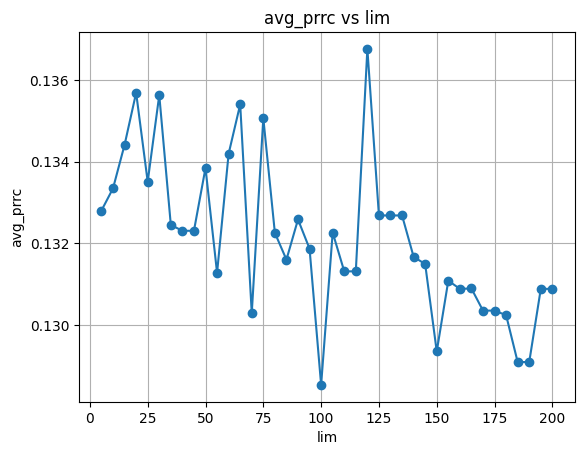

In [673]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

Our choose of 30 before has been good although not the best. Because of the trend that lower lim made it higher, we just take 30 not 120. But we may use in the next experiment.

## Mini Experiment 2

In [677]:
def mini_exp_device(lim):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_total_contacts',
    ]].copy()
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts
    
    df_bs = df_bs.drop(['brand', 'device_codename'], axis=1)
    
    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype("category")
    df_bs.de_employment_type = df_bs.de_employment_type.astype("category")
    df_bs.de_education = df_bs.de_education.astype("category")
    df_bs.de_marital_status = df_bs.de_marital_status.astype("category")
    df_bs.de_children = df_bs.de_children.astype("category")
    
    # df_bs = pd.get_dummies(df_bs)
    df_bs.device_codename_grouped = df_bs.device_codename_grouped.astype("category")
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(enable_categorical=True)
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [678]:
results = [mini_exp_device(i) for i in range(5,205,5)]

In [679]:
df_res = pd.DataFrame(results)

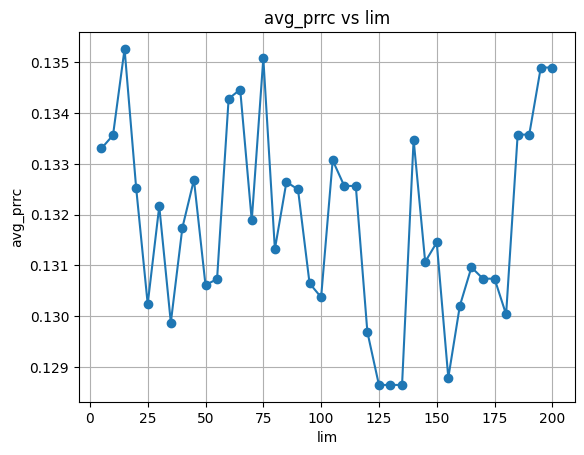

In [680]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In this experiment we use the enable categorical feature in XGBoost. The result is not much changed from before.

# Fourth Experiment

In [683]:
df.ph_call_log_stats[0]

'{"percent_incoming_nighttime": 1.83, "percent_outgoing_daytime": 28.44, "duration_incoming_daytime": 1195, "duration_outgoing_daytime": 1164, "percent_incoming_daytime": 3.67, "percent_other_calls": 2.75, "duration_outgoing_nighttime": 42358, "percent_outgoing_nighttime": 63.3, "total_calls": 109, "duration_incoming_nighttime": 293}'

In [781]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_call_log_stats',
    'ph_total_contacts',
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_call_log_stats,ph_total_contacts
0,0,26,1,2535,3000000,1,51,2,2,0,"{""percent_incoming_nighttime"": 1.83, ""percent_...",66
1,0,22,1,685,4000000,1,28,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",69
2,1,32,1,1765,7000000,1,35,4,2,2,"{""percent_incoming_nighttime"": 6.65, ""percent_...",315
3,0,31,2,407,20000000,3,37,3,2,2,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",84
4,0,27,1,3064,3000000,1,36,3,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,"{""percent_incoming_nighttime"": 5.66, ""percent_...",1026
41018,0,26,1,955,3000000,2,24,2,1,0,"{""percent_incoming_nighttime"": 10.71, ""percent...",0
41019,0,22,2,881,3000000,1,9,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",272
41020,0,29,2,540,6000000,1,51,2,1,0,"{""percent_incoming_nighttime"": 1.27, ""percent_...",0


In [782]:
df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
df_bs = pd.concat([df_bs, df_device], axis=1)
del df_device

In [783]:
df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
df_call_log_stats = df_call_log_stats.fillna(df_call_log_stats.median())
df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
del df_call_log_stats
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,...,percent_incoming_nighttime,percent_outgoing_daytime,duration_incoming_daytime,duration_outgoing_daytime,percent_incoming_daytime,percent_other_calls,duration_outgoing_nighttime,percent_outgoing_nighttime,total_calls,duration_incoming_nighttime
0,0,26,1,2535,3000000,1,51,2,2,0,...,1.83,28.44,1195.0,1164.0,3.67,2.75,42358.0,63.30,109.0,293.0
1,0,22,1,685,4000000,1,28,4,1,0,...,0.00,100.00,0.0,0.0,0.00,0.00,0.0,0.00,2.0,0.0
2,1,32,1,1765,7000000,1,35,4,2,2,...,6.65,41.76,5212.0,5490.0,13.56,13.30,2911.0,24.73,376.0,1846.0
3,0,31,2,407,20000000,3,37,3,2,2,...,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0
4,0,27,1,3064,3000000,1,36,3,1,0,...,0.00,46.67,0.0,14.0,0.00,0.00,84.0,53.33,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,...,5.66,42.42,7960.0,7889.0,22.22,13.74,2356.0,15.96,495.0,1786.0
41018,0,26,1,955,3000000,2,24,2,1,0,...,10.71,42.86,465.0,322.0,17.86,10.71,305.0,17.86,56.0,123.0
41019,0,22,2,881,3000000,1,9,4,1,0,...,0.00,43.75,1190.0,74.0,16.67,14.58,21.0,25.00,48.0,0.0
41020,0,29,2,540,6000000,1,51,2,1,0,...,1.27,40.13,3081.0,405.0,22.93,31.21,170.0,4.46,157.0,8.0


In [784]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  int64  
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  int64  
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  int64  
 8   de_marital_status            41022 non-null  int64  
 9   de_children                  41022 non-null  int64  
 10  ph_call_log_stats            38935 non-null  object 
 11  ph_total_contacts            41022 non-null  int64  
 12  device_codename              41022 non-null  object 
 13  brand           

In [785]:
counts = df_bs["device_codename"].value_counts()

df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
    lambda x: x if counts[x] > 150 else "others"
)
del counts

In [786]:
df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats'], axis=1)

In [787]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [788]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  object 
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  object 
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  object 
 8   de_marital_status            41022 non-null  object 
 9   de_children                  41022 non-null  object 
 10  ph_total_contacts            41022 non-null  int64  
 11  percent_incoming_nighttime   41022 non-null  float64
 12  percent_outgoing_daytime     41022 non-null  float64
 13  duration_incomin

In [789]:
df_bs = pd.get_dummies(df_bs)

In [790]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [791]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [792]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [793]:
y_pred = model.predict(X_test)

In [794]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7167
           1       0.51      0.07      0.12      1038

    accuracy                           0.87      8205
   macro avg       0.70      0.53      0.52      8205
weighted avg       0.83      0.87      0.83      8205



In [795]:
average_precision_score(y_test, y_pred)

0.15232786359334144

Based on optimization experiment below, we can fill lim with 25 if filled with 0 or 150 if filled with median

## Mini Exp Fill with 0 or median

In [883]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
    ]].copy()
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats'], axis=1)
    
    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier()
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [797]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [798]:
df_res = pd.DataFrame(results)

In [802]:
df_res.head()

,lim,avg_prrc
0,5,0.149713
1,10,0.142994
2,15,0.145700
3,20,0.144787
4,25,0.150976


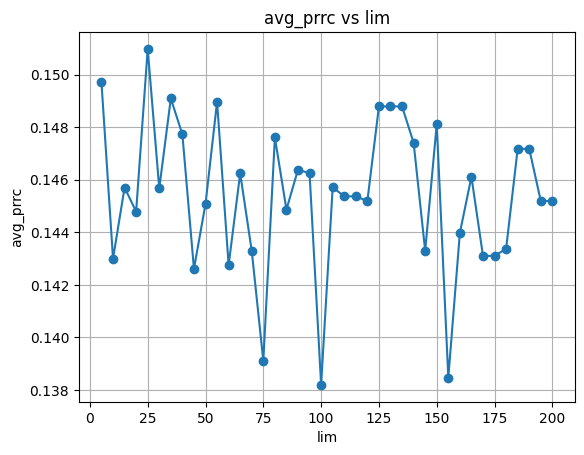

In [799]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [803]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [804]:
df_res = pd.DataFrame(results)

In [807]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.144842
26,135,0.144842
27,140,0.139133
28,145,0.146852
29,150,0.152328


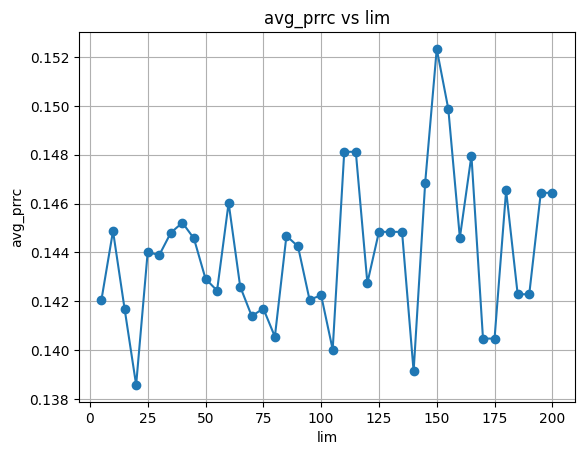

In [805]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [809]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [810]:
df_res = pd.DataFrame(results)

In [814]:
df_res[15:20]

,lim,avg_prrc
15,80,0.148677
16,85,0.146657
17,90,0.150501
18,95,0.140771
19,100,0.140872


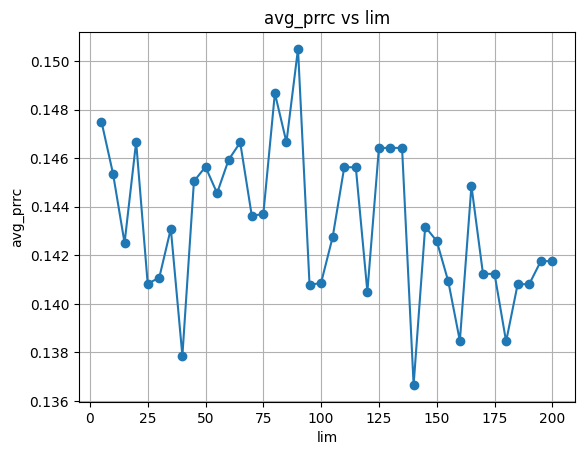

In [811]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [884]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [885]:
df_res = pd.DataFrame(results)

In [887]:
df_res[20:25]

,lim,avg_prrc
20,105,0.145736
21,110,0.144849
22,115,0.144849
23,120,0.153263
24,125,0.144841


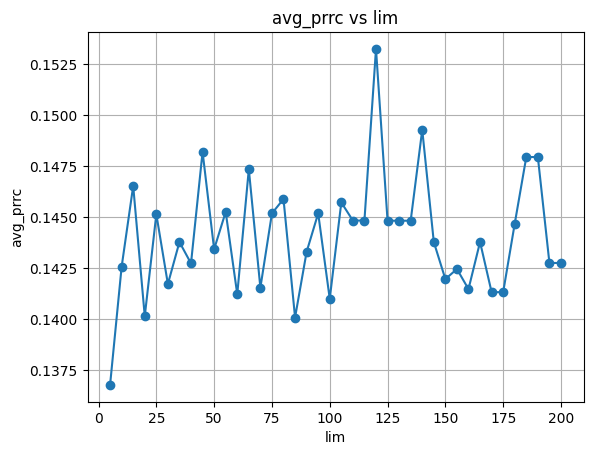

In [886]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Fifth Experiment

Here we assume the fb last updated date is recorded when he joined. The idea is we can know how long he has been inactive since it. In there we treat nan as information also and we assume there's no update on the FB.

In [922]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_call_log_stats',
    'ph_total_contacts',
    'de_date_joined',
    'fb_last_updated_date'
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_call_log_stats,ph_total_contacts,de_date_joined,fb_last_updated_date
0,0,26,1,2535,3000000,1,51,2,2,0,"{""percent_incoming_nighttime"": 1.83, ""percent_...",66,08/04/2018 14:50,2017-12-21T04:38:00+0000
1,0,22,1,685,4000000,1,28,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",69,02/01/2018 17:17,2017-11-25T17:23:09+0000
2,1,32,1,1765,7000000,1,35,4,2,2,"{""percent_incoming_nighttime"": 6.65, ""percent_...",315,01/01/2018 16:39,2017-12-23T18:05:57+0000
3,0,31,2,407,20000000,3,37,3,2,2,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",84,04/01/2018 22:36,2017-12-05T09:37:19+0000
4,0,27,1,3064,3000000,1,36,3,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",0,02/01/2018 18:12,2017-12-03T09:09:48+0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,"{""percent_incoming_nighttime"": 5.66, ""percent_...",1026,11/07/2018 22:23,NaN
41018,0,26,1,955,3000000,2,24,2,1,0,"{""percent_incoming_nighttime"": 10.71, ""percent...",0,11/07/2018 20:28,NaN
41019,0,22,2,881,3000000,1,9,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",272,11/07/2018 23:33,2017-10-25T08:05:13+0000
41020,0,29,2,540,6000000,1,51,2,1,0,"{""percent_incoming_nighttime"": 1.27, ""percent_...",0,11/07/2018 22:03,NaN


In [923]:
joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")

df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
del joined, updated

In [924]:
df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
df_bs = pd.concat([df_bs, df_device], axis=1)
del df_device

In [925]:
df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
df_call_log_stats = df_call_log_stats.fillna(0)
df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
del df_call_log_stats
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,...,percent_incoming_nighttime,percent_outgoing_daytime,duration_incoming_daytime,duration_outgoing_daytime,percent_incoming_daytime,percent_other_calls,duration_outgoing_nighttime,percent_outgoing_nighttime,total_calls,duration_incoming_nighttime
0,0,26,1,2535,3000000,1,51,2,2,0,...,1.83,28.44,1195.0,1164.0,3.67,2.75,42358.0,63.30,109.0,293.0
1,0,22,1,685,4000000,1,28,4,1,0,...,0.00,100.00,0.0,0.0,0.00,0.00,0.0,0.00,2.0,0.0
2,1,32,1,1765,7000000,1,35,4,2,2,...,6.65,41.76,5212.0,5490.0,13.56,13.30,2911.0,24.73,376.0,1846.0
3,0,31,2,407,20000000,3,37,3,2,2,...,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0
4,0,27,1,3064,3000000,1,36,3,1,0,...,0.00,46.67,0.0,14.0,0.00,0.00,84.0,53.33,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,...,5.66,42.42,7960.0,7889.0,22.22,13.74,2356.0,15.96,495.0,1786.0
41018,0,26,1,955,3000000,2,24,2,1,0,...,10.71,42.86,465.0,322.0,17.86,10.71,305.0,17.86,56.0,123.0
41019,0,22,2,881,3000000,1,9,4,1,0,...,0.00,43.75,1190.0,74.0,16.67,14.58,21.0,25.00,48.0,0.0
41020,0,29,2,540,6000000,1,51,2,1,0,...,1.27,40.13,3081.0,405.0,22.93,31.21,170.0,4.46,157.0,8.0


In [926]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  int64  
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  int64  
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  int64  
 8   de_marital_status            41022 non-null  int64  
 9   de_children                  41022 non-null  int64  
 10  ph_call_log_stats            38935 non-null  object 
 11  ph_total_contacts            41022 non-null  int64  
 12  de_date_joined               41022 non-null  object 
 13  fb_last_updated_

In [927]:
counts = df_bs["device_codename"].value_counts()

df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
    lambda x: x if counts[x] > 85 else "others"
)
del counts

In [928]:
df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date'], axis=1)

In [929]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [930]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  object 
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  object 
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  object 
 8   de_marital_status            41022 non-null  object 
 9   de_children                  41022 non-null  object 
 10  ph_total_contacts            41022 non-null  int64  
 11  date_diff                    39552 non-null  float64
 12  percent_incoming_nighttime   41022 non-null  float64
 13  percent_outgoing

In [931]:
df_bs = pd.get_dummies(df_bs)

In [932]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [933]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [934]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [935]:
y_pred = model.predict(X_test)

In [936]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7167
           1       0.53      0.07      0.12      1038

    accuracy                           0.87      8205
   macro avg       0.71      0.53      0.53      8205
weighted avg       0.84      0.87      0.83      8205



In [937]:
average_precision_score(y_test, y_pred)

0.15373909013308368

It increased but looking at the mini experiment, mostly its not increasing. So in the next experiment we may not include it and look at another feature experimentation first (continue from fourth experiment again)

## Mini Experiment

In [905]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
    ]].copy()

    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier()
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [906]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [907]:
df_res = pd.DataFrame(results)

In [908]:
df_res.head()

,lim,avg_prrc
0,5,0.144211
1,10,0.141349
2,15,0.143692
3,20,0.144860
4,25,0.143446


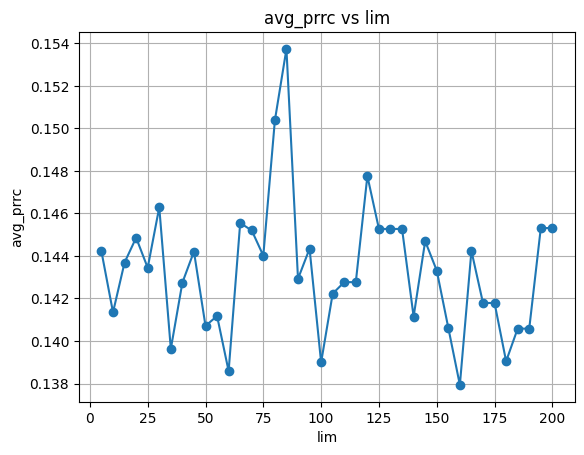

In [909]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [910]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [911]:
df_res = pd.DataFrame(results)

In [912]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.145240
26,135,0.145240
27,140,0.144246
28,145,0.145200
29,150,0.138941


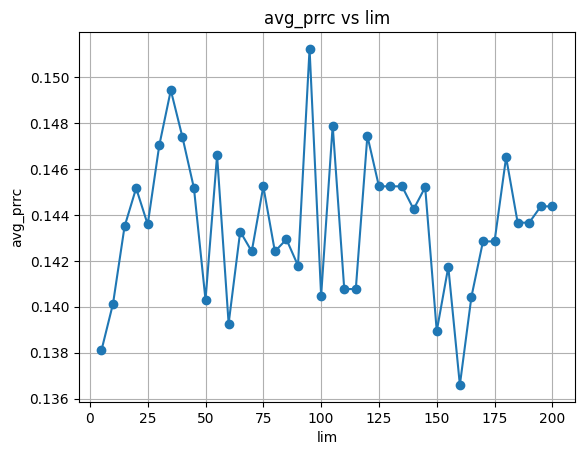

In [913]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [914]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [915]:
df_res = pd.DataFrame(results)

In [916]:
df_res[15:20]

,lim,avg_prrc
15,80,0.141704
16,85,0.144697
17,90,0.144179
18,95,0.147511
19,100,0.146276


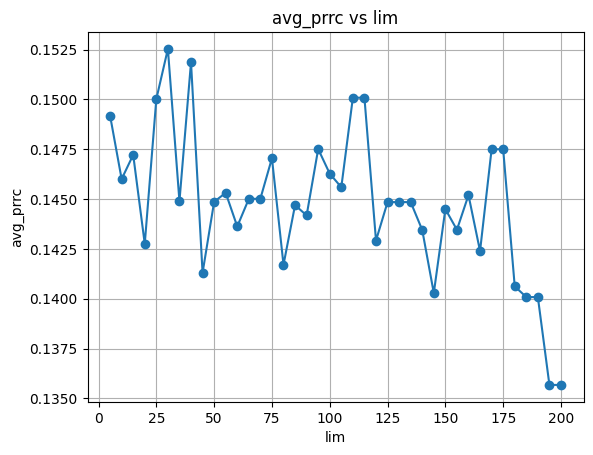

In [917]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [918]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [919]:
df_res = pd.DataFrame(results)

In [920]:
df_res[20:25]

,lim,avg_prrc
20,105,0.143627
21,110,0.143796
22,115,0.143796
23,120,0.141919
24,125,0.145569


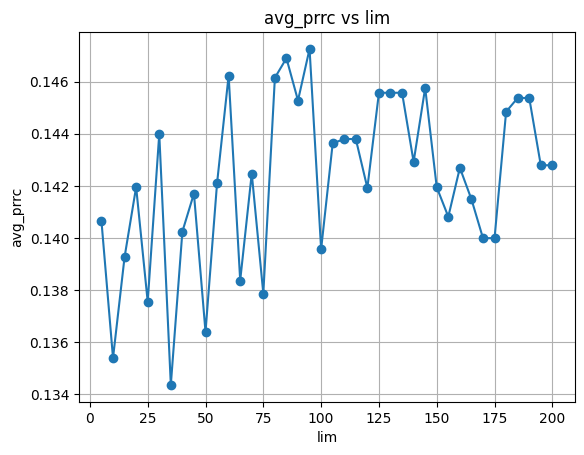

In [921]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Sixth Experiment

In [947]:
import ast
allde = set([app for sublist in df['ph_app_list'].dropna().apply(ast.literal_eval) for app in sublist])
len(allde)

85014

We have 85014 unique apps across all these users. We can feature engineering it by tagging specific keyword like slot, casino, or even another bnpl app. Lets convert to csv to be analyzed.

In [949]:
from collections import Counter

all_apps = df['ph_app_list'].dropna().apply(ast.literal_eval)
freq = Counter(app for sublist in all_apps for app in sublist)

app_counts = pd.DataFrame(freq.items(), columns=["app", "count_users"]).sort_values("count_users", ascending=False)

In [950]:
app_counts.to_csv("app_counts.csv", index=False)

In [993]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_call_log_stats',
    'ph_total_contacts',
    'de_date_joined',
    'fb_last_updated_date',
    'ph_app_list'
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_call_log_stats,ph_total_contacts,de_date_joined,fb_last_updated_date,ph_app_list
0,0,26,1,2535,3000000,1,51,2,2,0,"{""percent_incoming_nighttime"": 1.83, ""percent_...",66,08/04/2018 14:50,2017-12-21T04:38:00+0000,"['com.google.android.music', 'com.facebook.orc..."
1,0,22,1,685,4000000,1,28,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",69,02/01/2018 17:17,2017-11-25T17:23:09+0000,"['com.google.android.instantapps.supervisor', ..."
2,1,32,1,1765,7000000,1,35,4,2,2,"{""percent_incoming_nighttime"": 6.65, ""percent_...",315,01/01/2018 16:39,2017-12-23T18:05:57+0000,"['com.tencent.ibg.joox', 'com.mrgames.larvaact..."
3,0,31,2,407,20000000,3,37,3,2,2,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",84,04/01/2018 22:36,2017-12-05T09:37:19+0000,"['com.kfit.fave', 'app.bpjs.mobile', 'com.redd..."
4,0,27,1,3064,3000000,1,36,3,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",0,02/01/2018 18:12,2017-12-03T09:09:48+0000,"['com.lenovo.anyshare.gps', 'com.UCMobile.intl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,"{""percent_incoming_nighttime"": 5.66, ""percent_...",1026,11/07/2018 22:23,NaN,"['com.instagram.android', 'com.google.android...."
41018,0,26,1,955,3000000,2,24,2,1,0,"{""percent_incoming_nighttime"": 10.71, ""percent...",0,11/07/2018 20:28,NaN,"['com.youmusic.magictiles', 'com.ayopop', 'com..."
41019,0,22,2,881,3000000,1,9,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",272,11/07/2018 23:33,2017-10-25T08:05:13+0000,"['com.grabtaxi.passenger', 'jp.co.translimit.b..."
41020,0,29,2,540,6000000,1,51,2,1,0,"{""percent_incoming_nighttime"": 1.27, ""percent_...",0,11/07/2018 22:03,NaN,"['cn.wps.moffice_eng', 'com.vuclip.viu', 'com...."


In [994]:
import re

categories = {
    "gambling": ["poker", "casino", "slot", "jackpot", "toto", "lotto","bet","bingo","blackjack","roulette","rummy","777","satta"],
    "clone": ["clone", "dual", "parallel", "multi", "cloner", "whatscan"],
    "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
    "finance_risky": ["loan", "cash", "kredit", "rupiah", "payday", "utang", "pinjaman", "fastcash", "moneycash", "cashloan"],
    "adult": ["live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
    "suspicious_utility": ["booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
}

# Create binary columns for each category
for cat, keywords in categories.items():
    df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
        lambda x: int(any(kw in x for kw in keywords))
    )

df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,...,ph_total_contacts,de_date_joined,fb_last_updated_date,ph_app_list,gambling,clone,modded,finance_risky,adult,suspicious_utility
0,0,26,1,2535,3000000,1,51,2,2,0,...,66,08/04/2018 14:50,2017-12-21T04:38:00+0000,"['com.google.android.music', 'com.facebook.orc...",0,1,0,0,0,0
1,0,22,1,685,4000000,1,28,4,1,0,...,69,02/01/2018 17:17,2017-11-25T17:23:09+0000,"['com.google.android.instantapps.supervisor', ...",1,0,1,0,0,0
2,1,32,1,1765,7000000,1,35,4,2,2,...,315,01/01/2018 16:39,2017-12-23T18:05:57+0000,"['com.tencent.ibg.joox', 'com.mrgames.larvaact...",1,1,0,0,1,1
3,0,31,2,407,20000000,3,37,3,2,2,...,84,04/01/2018 22:36,2017-12-05T09:37:19+0000,"['com.kfit.fave', 'app.bpjs.mobile', 'com.redd...",1,0,0,1,0,0
4,0,27,1,3064,3000000,1,36,3,1,0,...,0,02/01/2018 18:12,2017-12-03T09:09:48+0000,"['com.lenovo.anyshare.gps', 'com.UCMobile.intl...",0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,...,1026,11/07/2018 22:23,NaN,"['com.instagram.android', 'com.google.android....",1,0,0,0,1,0
41018,0,26,1,955,3000000,2,24,2,1,0,...,0,11/07/2018 20:28,NaN,"['com.youmusic.magictiles', 'com.ayopop', 'com...",0,1,0,0,1,0
41019,0,22,2,881,3000000,1,9,4,1,0,...,272,11/07/2018 23:33,2017-10-25T08:05:13+0000,"['com.grabtaxi.passenger', 'jp.co.translimit.b...",0,0,1,0,1,0
41020,0,29,2,540,6000000,1,51,2,1,0,...,0,11/07/2018 22:03,NaN,"['cn.wps.moffice_eng', 'com.vuclip.viu', 'com....",0,0,0,0,1,0


In [995]:
joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")

df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
del joined, updated

In [996]:
df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
df_bs = pd.concat([df_bs, df_device], axis=1)
del df_device

In [997]:
df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
df_call_log_stats = df_call_log_stats.fillna(0)
df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
del df_call_log_stats
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,...,percent_incoming_nighttime,percent_outgoing_daytime,duration_incoming_daytime,duration_outgoing_daytime,percent_incoming_daytime,percent_other_calls,duration_outgoing_nighttime,percent_outgoing_nighttime,total_calls,duration_incoming_nighttime
0,0,26,1,2535,3000000,1,51,2,2,0,...,1.83,28.44,1195.0,1164.0,3.67,2.75,42358.0,63.30,109.0,293.0
1,0,22,1,685,4000000,1,28,4,1,0,...,0.00,100.00,0.0,0.0,0.00,0.00,0.0,0.00,2.0,0.0
2,1,32,1,1765,7000000,1,35,4,2,2,...,6.65,41.76,5212.0,5490.0,13.56,13.30,2911.0,24.73,376.0,1846.0
3,0,31,2,407,20000000,3,37,3,2,2,...,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0
4,0,27,1,3064,3000000,1,36,3,1,0,...,0.00,46.67,0.0,14.0,0.00,0.00,84.0,53.33,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,...,5.66,42.42,7960.0,7889.0,22.22,13.74,2356.0,15.96,495.0,1786.0
41018,0,26,1,955,3000000,2,24,2,1,0,...,10.71,42.86,465.0,322.0,17.86,10.71,305.0,17.86,56.0,123.0
41019,0,22,2,881,3000000,1,9,4,1,0,...,0.00,43.75,1190.0,74.0,16.67,14.58,21.0,25.00,48.0,0.0
41020,0,29,2,540,6000000,1,51,2,1,0,...,1.27,40.13,3081.0,405.0,22.93,31.21,170.0,4.46,157.0,8.0


In [998]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  int64  
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  int64  
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  int64  
 8   de_marital_status            41022 non-null  int64  
 9   de_children                  41022 non-null  int64  
 10  ph_call_log_stats            38935 non-null  object 
 11  ph_total_contacts            41022 non-null  int64  
 12  de_date_joined               41022 non-null  object 
 13  fb_last_updated_

In [999]:
counts = df_bs["device_codename"].value_counts()

df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
    lambda x: x if counts[x] > 10 else "others"
)
del counts

In [1000]:
df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list'], axis=1)

In [1001]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [1002]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  object 
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  object 
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  object 
 8   de_marital_status            41022 non-null  object 
 9   de_children                  41022 non-null  object 
 10  ph_total_contacts            41022 non-null  int64  
 11  gambling                     41022 non-null  int64  
 12  clone                        41022 non-null  int64  
 13  modded          

In [1003]:
df_bs = pd.get_dummies(df_bs)

In [1004]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [1005]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1006]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [1007]:
y_pred = model.predict(X_test)

In [1008]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      7167
           1       0.50      0.12      0.19      1038

    accuracy                           0.87      8205
   macro avg       0.69      0.55      0.56      8205
weighted avg       0.84      0.87      0.84      8205



In [1009]:
average_precision_score(y_test, y_pred)

0.16956853779994344

## Mini Experiment

In [976]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
    ]].copy()

    categories = {
        "gambling": ["poker", "casino", "slot", "jackpot", "toto", "lotto","bet","bingo","blackjack","roulette","rummy","777","satta"],
        "clone": ["clone", "dual", "parallel", "multi", "cloner", "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ["loan", "cash", "kredit", "rupiah", "payday", "utang", "pinjaman", "fastcash", "moneycash", "cashloan"],
        "adult": ["live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ["booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier()
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [977]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [978]:
df_res = pd.DataFrame(results)

In [979]:
df_res.head()

,lim,avg_prrc
0,5,0.163577
1,10,0.169569
2,15,0.165375
3,20,0.159073
4,25,0.164814


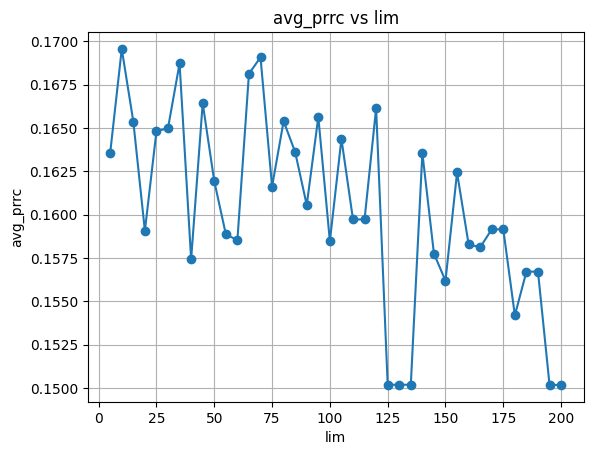

In [980]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [981]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [982]:
df_res = pd.DataFrame(results)

In [983]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.158287
26,135,0.158287
27,140,0.164375
28,145,0.157967
29,150,0.161983


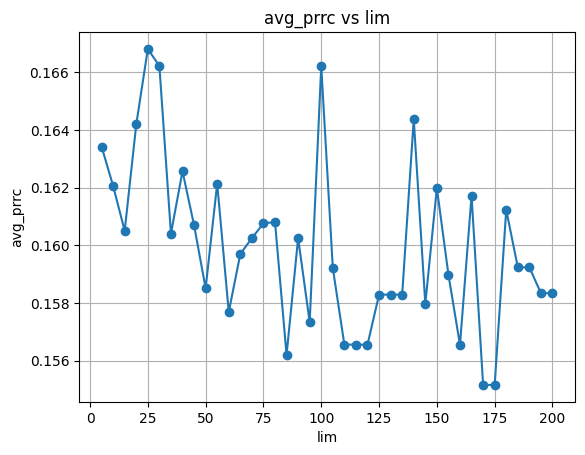

In [984]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [985]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [986]:
df_res = pd.DataFrame(results)

In [987]:
df_res[15:20]

,lim,avg_prrc
15,80,0.161197
16,85,0.155318
17,90,0.158554
18,95,0.163785
19,100,0.157007


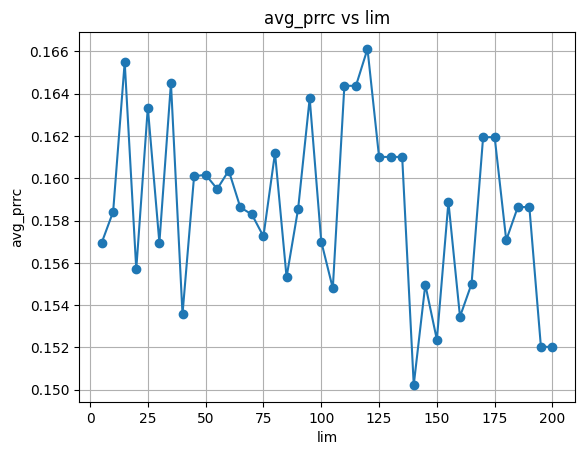

In [988]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [989]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [990]:
df_res = pd.DataFrame(results)

In [991]:
df_res[20:25]

,lim,avg_prrc
20,105,0.161844
21,110,0.168399
22,115,0.168399
23,120,0.163717
24,125,0.165570


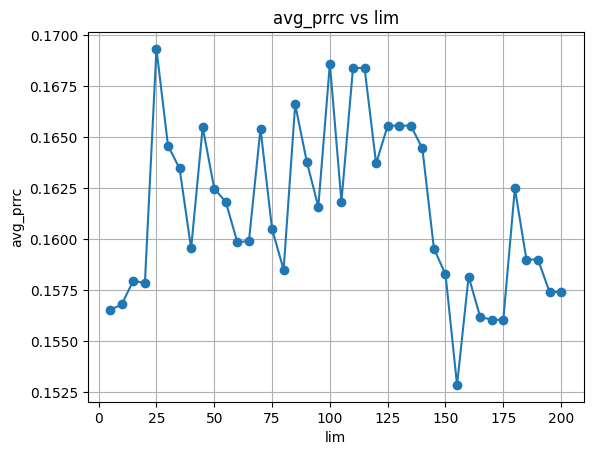

In [992]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Seventh Experiment

In [33]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
    ]].copy()

    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [34]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [35]:
df_res = pd.DataFrame(results)

In [36]:
df_res.head()

,lim,avg_prrc
0,5,0.156531
1,10,0.157755
2,15,0.156222
3,20,0.161429
4,25,0.163151


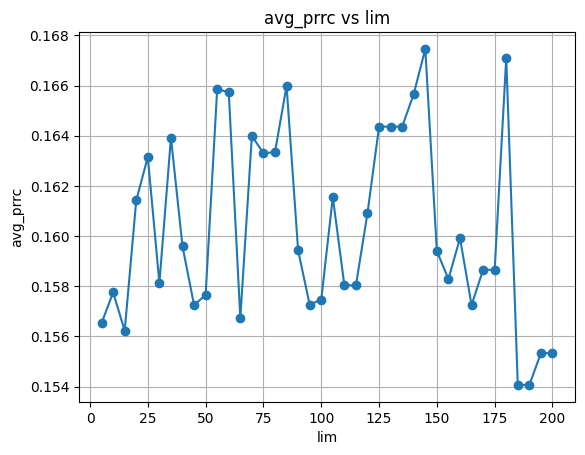

In [37]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [38]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [39]:
df_res = pd.DataFrame(results)

In [40]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.168996
26,135,0.168996
27,140,0.166448
28,145,0.159045
29,150,0.158174


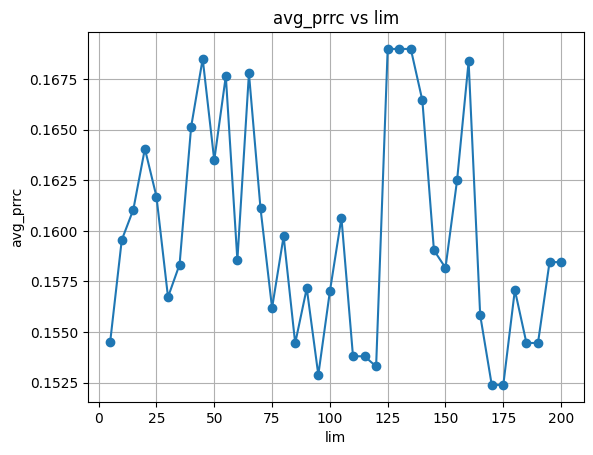

In [41]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [42]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [43]:
df_res = pd.DataFrame(results)

In [47]:
df_res[5:10]

,lim,avg_prrc
5,30,0.170602
6,35,0.163870
7,40,0.157846
8,45,0.153626
9,50,0.167050


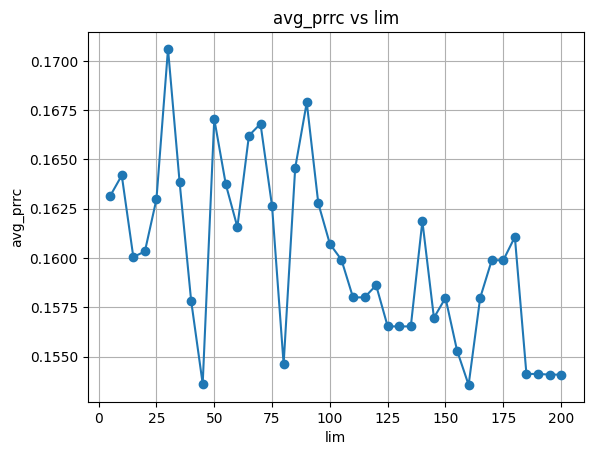

In [45]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [48]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [49]:
df_res = pd.DataFrame(results)

In [52]:
df_res[-5:]

,lim,avg_prrc
35,180,0.154631
36,185,0.173886
37,190,0.173886
38,195,0.157064
39,200,0.157064


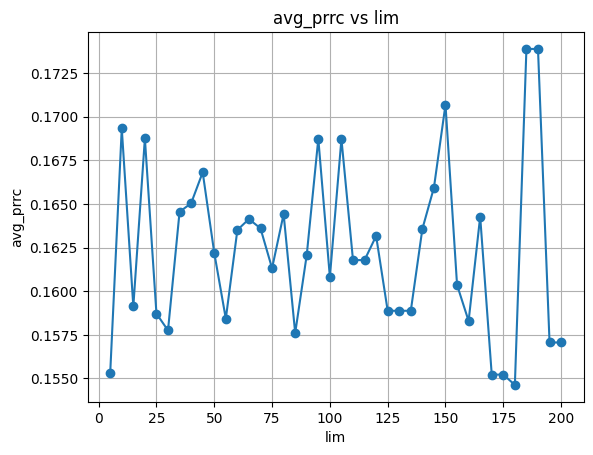

In [51]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Eighth Experiment

Now the idea coming from fb age. Is he lying about his age or not? Unstated also counted, can be indication too.

In [60]:
df.de_age.describe()

count    41022.000000
mean        28.170908
std          6.537795
min         18.000000
25%         23.000000
50%         27.000000
75%         32.000000
max         73.000000
Name: de_age, dtype: float64

In [82]:
(((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365).describe()

count    31369.000000
mean        29.359470
std          9.984007
min         13.492192
25%         23.824612
50%         27.309433
75%         32.209488
max        113.547666
dtype: float64

In [83]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob'
    ]].copy()

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [84]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [85]:
df_res = pd.DataFrame(results)

In [86]:
df_res.head()

,lim,avg_prrc
0,5,0.157851
1,10,0.163963
2,15,0.160278
3,20,0.154852
4,25,0.162989


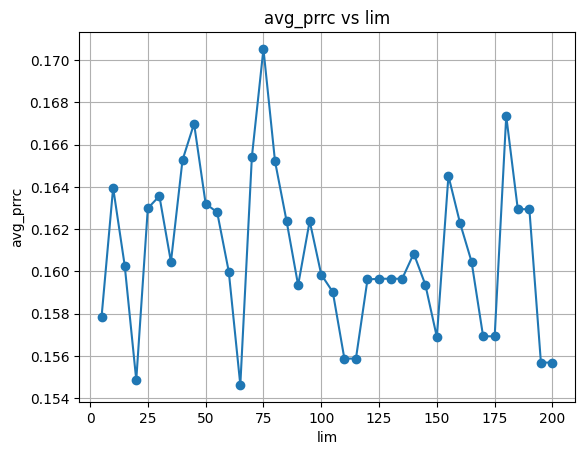

In [87]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [88]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [89]:
df_res = pd.DataFrame(results)

In [90]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.162938
26,135,0.162938
27,140,0.161471
28,145,0.162851
29,150,0.161587


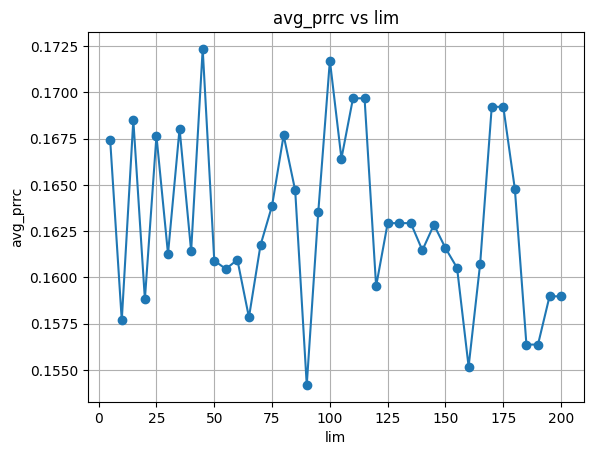

In [91]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [92]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [93]:
df_res = pd.DataFrame(results)

In [94]:
df_res[5:10]

,lim,avg_prrc
5,30,0.158692
6,35,0.164565
7,40,0.158363
8,45,0.168636
9,50,0.161005


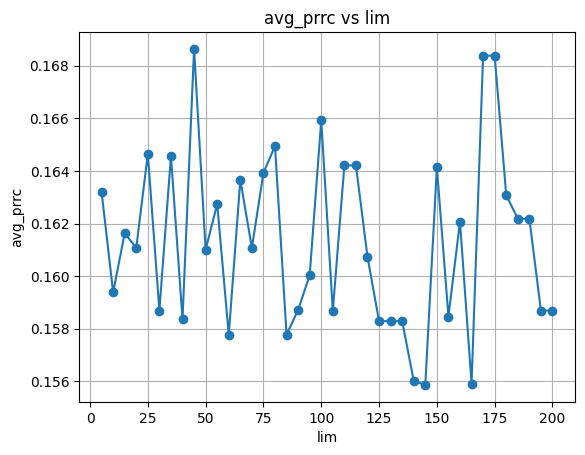

In [95]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [96]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [97]:
df_res = pd.DataFrame(results)

In [98]:
df_res[-5:]

,lim,avg_prrc
35,180,0.172607
36,185,0.157764
37,190,0.157764
38,195,0.157432
39,200,0.157432


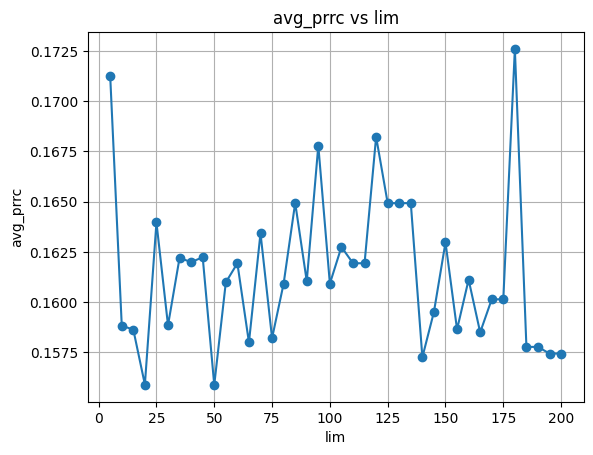

In [99]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Ninth Experiment

Here the idea is we guess that pending status in facebook is something that needs to be tracked, because its not verified by the other partner.

In [100]:
df.fb_relation.value_counts()

fb_relation
Married                                6327
Single                                 4495
In a relationship                      1847
Engaged                                 812
It's complicated                        362
In an open relationship                 158
Married (Pending)                       154
In a domestic partnership               118
Separated                               110
Divorced                                 59
Widowed                                  57
In a relationship (Pending)              28
Engaged (Pending)                        22
In a civil union                          5
In an open relationship (Pending)         3
In a domestic partnership (Pending)       3
It's complicated (Pending)                1
Name: count, dtype: int64

In [104]:
df.fb_relation.str.contains('Pending').value_counts()

fb_relation
False    14350
True       211
Name: count, dtype: int64

In [122]:
df.fb_relation.str.replace(' (Pending)', '').value_counts()

fb_relation
Married                      6481
Single                       4495
In a relationship            1875
Engaged                       834
It's complicated              363
In an open relationship       161
In a domestic partnership     121
Separated                     110
Divorced                       59
Widowed                        57
In a civil union                5
Name: count, dtype: int64

In [ ]:
# df.fb_relation = df.fb_relation.str.replace(' (Pending)', '')
# df.fb_relation = df.fb_relation.str.replace('In a civil union', 'In a domestic partnership')

In [242]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation'
    ]].copy()

    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df_bs.fb_relation.str.contains('Pending')
    df_bs.fb_relation = df_bs.fb_relation.str.replace(' (Pending)', '')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a civil union', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a domestic partnership', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [243]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [244]:
df_res = pd.DataFrame(results)

In [245]:
df_res.head()

,lim,avg_prrc
0,5,0.166928
1,10,0.156055
2,15,0.158156
3,20,0.161413
4,25,0.163490


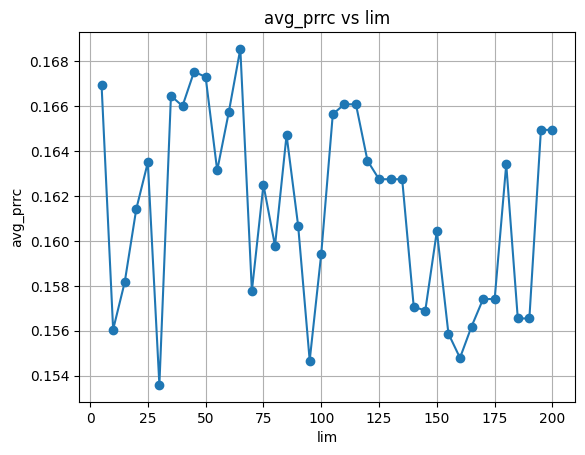

In [246]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [247]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [248]:
df_res = pd.DataFrame(results)

In [249]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.157772
26,135,0.157772
27,140,0.160955
28,145,0.163207
29,150,0.160789


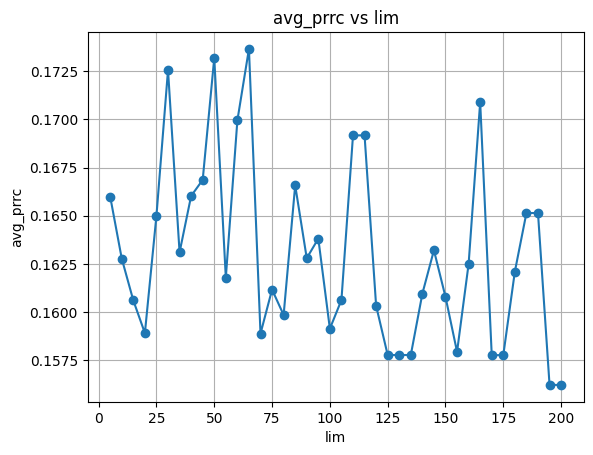

In [250]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [251]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [252]:
df_res = pd.DataFrame(results)

In [253]:
df_res[5:10]

,lim,avg_prrc
5,30,0.159138
6,35,0.174788
7,40,0.171368
8,45,0.163288
9,50,0.163927


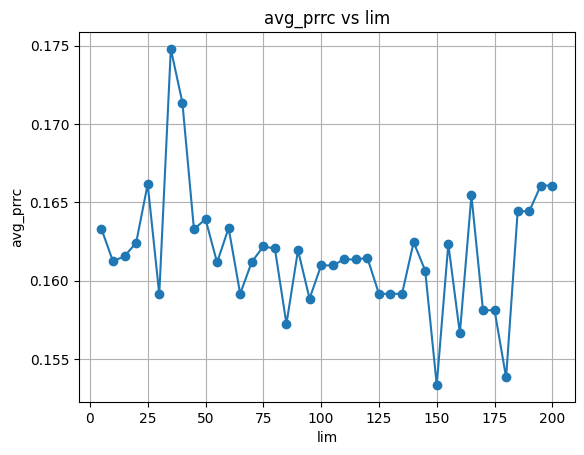

In [254]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [255]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [256]:
df_res = pd.DataFrame(results)

In [257]:
df_res[-5:]

,lim,avg_prrc
35,180,0.156206
36,185,0.160560
37,190,0.160560
38,195,0.171727
39,200,0.171727


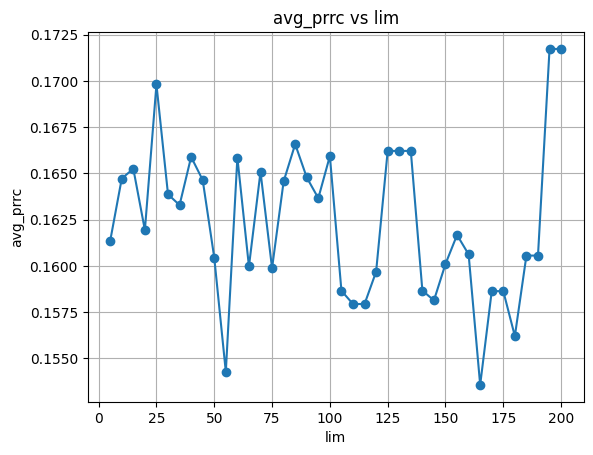

In [258]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Tenth Experiment

In [259]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation',
        'fb_gender'
    ]].copy()

    df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")
    
    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df_bs.fb_relation.str.contains('Pending')
    df_bs.fb_relation = df_bs.fb_relation.str.replace(' (Pending)', '')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a civil union', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a domestic partnership', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [260]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [261]:
df_res = pd.DataFrame(results)

In [262]:
df_res.head()

,lim,avg_prrc
0,5,0.161413
1,10,0.166350
2,15,0.168508
3,20,0.163092
4,25,0.165359


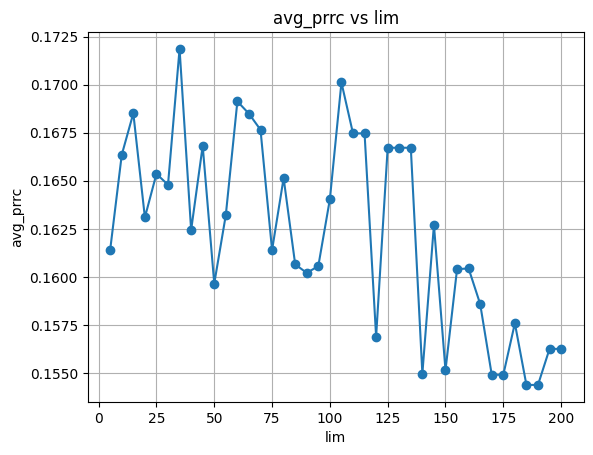

In [263]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [264]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [265]:
df_res = pd.DataFrame(results)

In [266]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.168010
26,135,0.168010
27,140,0.163813
28,145,0.162742
29,150,0.163167


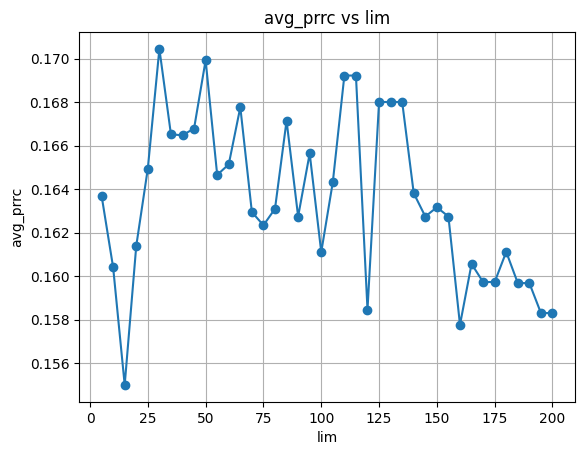

In [267]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [268]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [269]:
df_res = pd.DataFrame(results)

In [270]:
df_res[5:10]

,lim,avg_prrc
5,30,0.161521
6,35,0.169486
7,40,0.166286
8,45,0.169034
9,50,0.166934


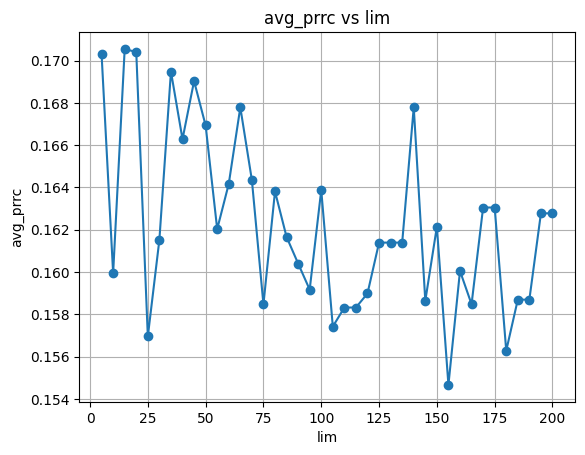

In [271]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [ ]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [ ]:
df_res = pd.DataFrame(results)

In [ ]:
df_res[-5:]

In [ ]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# 11 | XGBoost scaled

In [211]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation',
        'fb_gender'
    ]].copy()

    df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")
    
    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df.fb_relation.str.contains('Pending')
    df.fb_relation = df.fb_relation.str.replace(' (Pending)', '')
    df.fb_relation = df.fb_relation.str.replace('In a civil union', 'Married')
    df.fb_relation = df.fb_relation.str.replace('In a domestic partnership', 'Married')
    df.fb_relation = df.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
        scale_pos_weight=df.flag_bad.value_counts()[0]/df.flag_bad.value_counts()[1]
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [212]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [213]:
df_res = pd.DataFrame(results)

In [214]:
df_res.head()

,lim,avg_prrc
0,5,0.197503
1,10,0.196726
2,15,0.194492
3,20,0.193565
4,25,0.188465


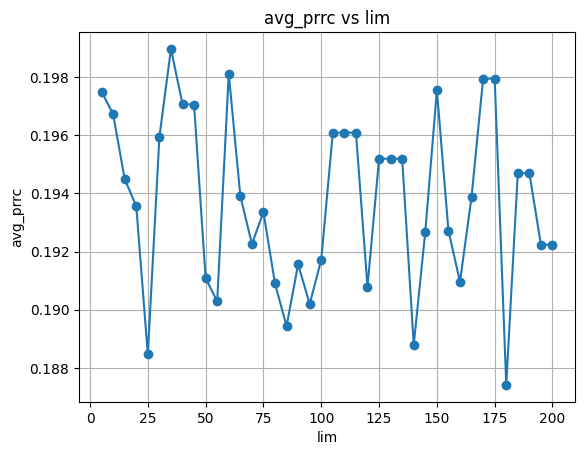

In [215]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [216]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [217]:
df_res = pd.DataFrame(results)

In [218]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.191489
26,135,0.191489
27,140,0.196185
28,145,0.189418
29,150,0.194729


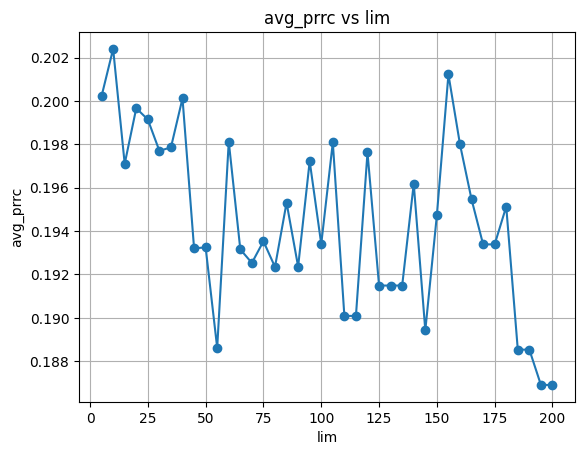

In [219]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [220]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [221]:
df_res = pd.DataFrame(results)

In [222]:
df_res[5:10]

,lim,avg_prrc
5,30,0.202378
6,35,0.199304
7,40,0.199565
8,45,0.201707
9,50,0.193932


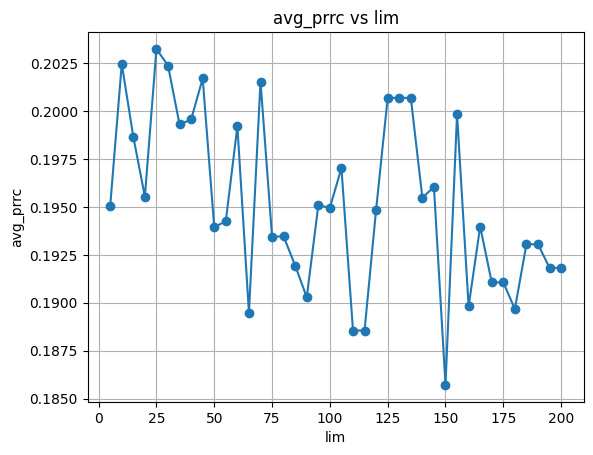

In [223]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [224]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [225]:
df_res = pd.DataFrame(results)

In [226]:
df_res[-5:]

,lim,avg_prrc
35,180,0.196682
36,185,0.193035
37,190,0.193035
38,195,0.192802
39,200,0.192802


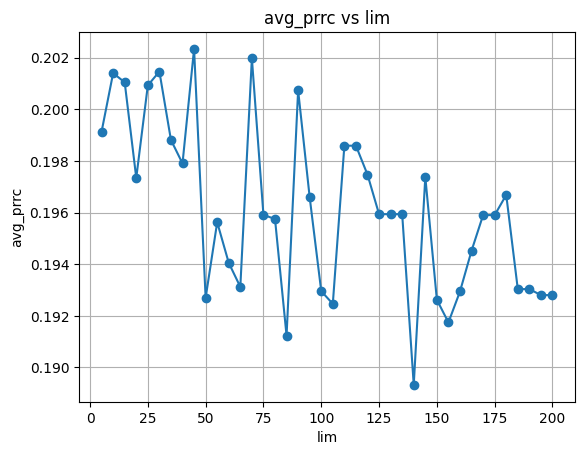

In [227]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# 12 | Smote

In [230]:
from imblearn.over_sampling import SMOTE

In [238]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation',
        'fb_gender'
    ]].copy()

    df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")
    
    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df.fb_relation.str.contains('Pending')
    df.fb_relation = df.fb_relation.str.replace(' (Pending)', '')
    df.fb_relation = df.fb_relation.str.replace('In a civil union', 'Married')
    df.fb_relation = df.fb_relation.str.replace('In a domestic partnership', 'Married')
    df.fb_relation = df.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    df_bs["date_diff"] = df_bs["date_diff"].fillna(9999)
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    print(df_bs.info())
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    smote = SMOTE(random_state=42)
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
        # scale_pos_weight=df.flag_bad.value_counts()[0]/df.flag_bad.value_counts()[1]
    )
    X_res, y_res = smote.fit_resample(X_train, y_train)
    model.fit(X_res, y_res)
    del X_train, y_train, X_res, y_res
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [239]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  object 
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  object 
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  object 
 8   de_marital_status            41022 non-null  object 
 9   de_children                  41022 non-null  object 
 10  ph_total_contacts            41022 non-null  int64  
 11  fb_relation                  41022 non-null  object 
 12  fb_gender                    41022 non-null  object 
 13  pending_relation

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
df_res = pd.DataFrame(results)

In [ ]:
df_res.head()

In [ ]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [ ]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [ ]:
df_res = pd.DataFrame(results)

In [ ]:
df_res[-15:-10]

In [ ]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [ ]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [ ]:
df_res = pd.DataFrame(results)

In [ ]:
df_res[5:10]

In [ ]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [ ]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [ ]:
df_res = pd.DataFrame(results)

In [ ]:
df_res[-5:]

In [ ]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# EDA